In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss
# remove warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from tqdm import tqdm
import time
import copy
import sklearn.metrics
from sklearn.metrics import confusion_matrix
!pip install oulumetrics
import oulumetrics

     |████████████████████████████████| 549 kB 906 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for oulumetrics: filename=oulumetrics-0.1-py3-none-any.whl size=2459 sha256=753b764e1e59c56b0b96e6f75f458f041068175827a6abbf6c82d945d7179219
  Stored in directory: /root/.cache/pip/wheels/7f/20/61/c35d3f8bc5bd6f14bf745850cfd35ef096ee31b26afc861fed
Successfully built oulumetrics


In [2]:
!pip install keras
!pip install tensorflow-addons
!pip install gdown

!gdown --id 1hnKzb1cit2dePWwfRXmNG2kxCQS-oGJy
!gdown --id 1BPI4EPPknI5FQ2t-MILqLI1bVWvf0D2U

!unzip Protocol1_new
!unzip undersampled_protocol1


/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hnKzb1cit2dePWwfRXmNG2kxCQS-oGJy
To: /kaggle/working/Protocol1_new.zip
100%|█████████████████████████████████████████| 594M/594M [00:02<00:00, 235MB/s]
/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1BPI4EPPknI5FQ2t-MILqLI1bVWvf0D2U
To: /kaggle/working/undersampled_protocol1.zip
100%|█████████████████████████████████████████| 212M/212M [00:01<00:00, 184MB/s]
Archive:  Protocol1_new.zip
  inflating: Protocol1_new/Protocol1_dev.csv  
   creating: Protocol1_new/Protocol1_seperated/
   creatin

In [3]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [4]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
#             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.20, value='random')
        ])
        train_data = datasets.ImageFolder('/kaggle/working/undersampled_protocol1/train_undersampled', transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "dev/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [5]:
dataset_path = "/kaggle/working/Protocol1_new/Protocol1_seperated/"

In [6]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(dev_loader, test_loader, dev_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [7]:
print(test_loader)

In [8]:
classes = get_classes("/kaggle/working/Protocol1_new/Protocol1_seperated/train/")
print(classes, len(classes))

['fake', 'true'] 2


In [9]:
dataloaders = {
    "train": train_loader,
    "val": dev_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": dev_data_len
}

In [10]:
print(len(train_loader), len(dev_loader), len(test_loader))

45 283 243


In [11]:
print(train_data_len, dev_data_len, test_data_len)

5663 9027 7758


In [12]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
# model_names = timm.list_models(pretrained=True)
# print(model_names)

In [14]:
pretrained_model_name = 'deit_base_patch16_224'   #cait_M48 cait_XXS36_224 cait_S24_224 deit_base_distilled_patch16_224 deit_base_patch16_224 deit_tiny_distilled_patch16_224
no_epochs = 100

In [15]:

learning_rate = 0.03
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    
#     nn.BatchNorm1d(192),
#     nn.Linear(n_inputs, 512),
#     nn.ReLU(),
# #     nn.BatchNorm1d(512),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(128, 64),
#     nn.ReLU(),
# #     nn.Dropout(0.2, inplace=True),
    
#     nn.Linear(64, len(classes))
    ############################################
    nn.BatchNorm1d(768),
    nn.Linear(n_inputs, 512),
    nn.Mish(),
#     nn.BatchNorm1d(512),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(512, 256),
    nn.Mish(),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(256, 128),
    nn.Mish(),
    nn.Dropout(0.2, inplace=True),
    nn.Linear(128, 64),
    nn.Mish(),
#     nn.Dropout(0.2, inplace=True),
    
    nn.Linear(64, len(classes))
    ##############################################
    
#     nn.BatchNorm1d(192),
# #     nn.Linear(n_inputs, 512),
#     nn.PReLU(),
# #     nn.BatchNorm1d(512),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(512, 256),
#     nn.PReLU(),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(256, 128),
#     nn.PReLU(),
#     nn.Dropout(0.2, inplace=True),
# #     nn.Linear(128, 64),
#     nn.PReLU(),
    #################################
#     nn.Linear(n_inputs, 512),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(512, len(classes))
)

# model.head = head_params
model = model.to(device)
# print(model)
# parameters


Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [16]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.SGD(model.head.parameters(), lr=learning_rate, momentum=0.5)

In [17]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [18]:
train_accs = []
val_accs = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
#                     print(outputs)
                    _, preds = torch.max(outputs,1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                val_accs.append(epoch_acc)
            else:
                train_accs.append(epoch_acc)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [19]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=no_epochs) 


Epoch 0/99
----------


100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


train Loss: 0.6914 Acc: 0.5169


100%|██████████| 283/283 [00:58<00:00,  4.84it/s]


val Loss: 0.7112 Acc: 0.2321

Epoch 1/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.6872 Acc: 0.5478


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.7004 Acc: 0.2880

Epoch 2/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.6799 Acc: 0.6219


100%|██████████| 283/283 [00:58<00:00,  4.81it/s]


val Loss: 0.6827 Acc: 0.6628

Epoch 3/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.6617 Acc: 0.7344


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.6499 Acc: 0.7655

Epoch 4/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.6078 Acc: 0.7607


100%|██████████| 283/283 [00:58<00:00,  4.81it/s]


val Loss: 0.5358 Acc: 0.8243

Epoch 5/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.5143 Acc: 0.7948


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.4651 Acc: 0.8406

Epoch 6/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.4438 Acc: 0.8485


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.4384 Acc: 0.8495

Epoch 7/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.4066 Acc: 0.8769


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.4034 Acc: 0.8763

Epoch 8/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.3822 Acc: 0.8955


100%|██████████| 283/283 [00:59<00:00,  4.80it/s]


val Loss: 0.4037 Acc: 0.8785

Epoch 9/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.3533 Acc: 0.9144


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.4120 Acc: 0.8737

Epoch 10/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.3475 Acc: 0.9212


100%|██████████| 283/283 [00:59<00:00,  4.76it/s]


val Loss: 0.3809 Acc: 0.8969

Epoch 11/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.3378 Acc: 0.9267


100%|██████████| 283/283 [00:59<00:00,  4.80it/s]


val Loss: 0.3676 Acc: 0.9050

Epoch 12/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.3250 Acc: 0.9370


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3826 Acc: 0.8950

Epoch 13/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.3172 Acc: 0.9421


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3815 Acc: 0.8975

Epoch 14/99
----------


100%|██████████| 45/45 [00:37<00:00,  1.22it/s]


train Loss: 0.3134 Acc: 0.9446


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3638 Acc: 0.9073

Epoch 15/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.3030 Acc: 0.9507


100%|██████████| 283/283 [00:58<00:00,  4.81it/s]


val Loss: 0.3574 Acc: 0.9146

Epoch 16/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.3075 Acc: 0.9481


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3518 Acc: 0.9186

Epoch 17/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2991 Acc: 0.9534


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3618 Acc: 0.9109

Epoch 18/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2962 Acc: 0.9557


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3567 Acc: 0.9159

Epoch 19/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2948 Acc: 0.9566


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3595 Acc: 0.9100

Epoch 20/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2942 Acc: 0.9576


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3579 Acc: 0.9146

Epoch 21/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2903 Acc: 0.9604


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3608 Acc: 0.9109

Epoch 22/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2851 Acc: 0.9631


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3425 Acc: 0.9270

Epoch 23/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2882 Acc: 0.9603


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3500 Acc: 0.9186

Epoch 24/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2810 Acc: 0.9680


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3361 Acc: 0.9300

Epoch 25/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2828 Acc: 0.9636


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3459 Acc: 0.9210

Epoch 26/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2789 Acc: 0.9698


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3432 Acc: 0.9253

Epoch 27/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2740 Acc: 0.9714


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3326 Acc: 0.9318

Epoch 28/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2767 Acc: 0.9687


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3314 Acc: 0.9323

Epoch 29/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2770 Acc: 0.9698


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3382 Acc: 0.9262

Epoch 30/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2743 Acc: 0.9717


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3349 Acc: 0.9289

Epoch 31/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2732 Acc: 0.9730


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3488 Acc: 0.9187

Epoch 32/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2719 Acc: 0.9723


100%|██████████| 283/283 [00:59<00:00,  4.80it/s]


val Loss: 0.3323 Acc: 0.9304

Epoch 33/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2714 Acc: 0.9730


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3453 Acc: 0.9219

Epoch 34/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2712 Acc: 0.9726


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3365 Acc: 0.9277

Epoch 35/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2674 Acc: 0.9746


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3301 Acc: 0.9339

Epoch 36/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2683 Acc: 0.9739


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3322 Acc: 0.9302

Epoch 37/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2667 Acc: 0.9751


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3356 Acc: 0.9282

Epoch 38/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2714 Acc: 0.9714


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3311 Acc: 0.9305

Epoch 39/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2681 Acc: 0.9765


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3301 Acc: 0.9297

Epoch 40/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2626 Acc: 0.9788


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3224 Acc: 0.9373

Epoch 41/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2633 Acc: 0.9756


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3199 Acc: 0.9386

Epoch 42/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2627 Acc: 0.9793


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3340 Acc: 0.9272

Epoch 43/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2635 Acc: 0.9760


100%|██████████| 283/283 [00:58<00:00,  4.83it/s]


val Loss: 0.3293 Acc: 0.9308

Epoch 44/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2645 Acc: 0.9778


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3212 Acc: 0.9354

Epoch 45/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2619 Acc: 0.9785


100%|██████████| 283/283 [00:59<00:00,  4.80it/s]


val Loss: 0.3313 Acc: 0.9277

Epoch 46/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2596 Acc: 0.9800


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3290 Acc: 0.9308

Epoch 47/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2612 Acc: 0.9778


100%|██████████| 283/283 [00:59<00:00,  4.76it/s]


val Loss: 0.3265 Acc: 0.9300

Epoch 48/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2600 Acc: 0.9788


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3262 Acc: 0.9340

Epoch 49/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.2561 Acc: 0.9799


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3235 Acc: 0.9357

Epoch 50/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2563 Acc: 0.9822


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3205 Acc: 0.9349

Epoch 51/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.2581 Acc: 0.9797


100%|██████████| 283/283 [00:58<00:00,  4.84it/s]


val Loss: 0.3197 Acc: 0.9345

Epoch 52/99
----------


100%|██████████| 45/45 [00:37<00:00,  1.20it/s]


train Loss: 0.2550 Acc: 0.9846


100%|██████████| 283/283 [00:59<00:00,  4.76it/s]


val Loss: 0.3205 Acc: 0.9349

Epoch 53/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2553 Acc: 0.9806


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3190 Acc: 0.9362

Epoch 54/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2550 Acc: 0.9827


100%|██████████| 283/283 [00:58<00:00,  4.81it/s]


val Loss: 0.3196 Acc: 0.9346

Epoch 55/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.2542 Acc: 0.9800


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3236 Acc: 0.9319

Epoch 56/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2545 Acc: 0.9809


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3227 Acc: 0.9312

Epoch 57/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2546 Acc: 0.9809


100%|██████████| 283/283 [00:58<00:00,  4.81it/s]


val Loss: 0.3193 Acc: 0.9356

Epoch 58/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2516 Acc: 0.9845


100%|██████████| 283/283 [00:59<00:00,  4.78it/s]


val Loss: 0.3222 Acc: 0.9332

Epoch 59/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2506 Acc: 0.9841


100%|██████████| 283/283 [00:59<00:00,  4.76it/s]


val Loss: 0.3289 Acc: 0.9276

Epoch 60/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2502 Acc: 0.9846


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3149 Acc: 0.9381

Epoch 61/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2486 Acc: 0.9857


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3181 Acc: 0.9355

Epoch 62/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2509 Acc: 0.9823


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3166 Acc: 0.9387

Epoch 63/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2480 Acc: 0.9857


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3118 Acc: 0.9395

Epoch 64/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2506 Acc: 0.9820


100%|██████████| 283/283 [00:58<00:00,  4.84it/s]


val Loss: 0.3178 Acc: 0.9349

Epoch 65/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.2467 Acc: 0.9845


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3229 Acc: 0.9320

Epoch 66/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2495 Acc: 0.9827


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3181 Acc: 0.9360

Epoch 67/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2488 Acc: 0.9834


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3122 Acc: 0.9374

Epoch 68/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2460 Acc: 0.9852


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3134 Acc: 0.9387

Epoch 69/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2459 Acc: 0.9848


100%|██████████| 283/283 [00:59<00:00,  4.75it/s]


val Loss: 0.3108 Acc: 0.9389

Epoch 70/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2473 Acc: 0.9834


100%|██████████| 283/283 [00:59<00:00,  4.75it/s]


val Loss: 0.3079 Acc: 0.9394

Epoch 71/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2476 Acc: 0.9820


100%|██████████| 283/283 [00:58<00:00,  4.83it/s]


val Loss: 0.3117 Acc: 0.9373

Epoch 72/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2436 Acc: 0.9866


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3071 Acc: 0.9387

Epoch 73/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2450 Acc: 0.9845


100%|██████████| 283/283 [00:59<00:00,  4.74it/s]


val Loss: 0.3126 Acc: 0.9366

Epoch 74/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2439 Acc: 0.9841


100%|██████████| 283/283 [00:58<00:00,  4.83it/s]


val Loss: 0.3131 Acc: 0.9372

Epoch 75/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2413 Acc: 0.9862


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3120 Acc: 0.9355

Epoch 76/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2437 Acc: 0.9875


100%|██████████| 283/283 [00:59<00:00,  4.74it/s]


val Loss: 0.3147 Acc: 0.9353

Epoch 77/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2405 Acc: 0.9878


100%|██████████| 283/283 [00:59<00:00,  4.76it/s]


val Loss: 0.3056 Acc: 0.9411

Epoch 78/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.24it/s]


train Loss: 0.2414 Acc: 0.9866


100%|██████████| 283/283 [00:58<00:00,  4.83it/s]


val Loss: 0.3050 Acc: 0.9396

Epoch 79/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2381 Acc: 0.9864


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3106 Acc: 0.9360

Epoch 80/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2388 Acc: 0.9848


100%|██████████| 283/283 [00:59<00:00,  4.75it/s]


val Loss: 0.3138 Acc: 0.9352

Epoch 81/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2409 Acc: 0.9832


100%|██████████| 283/283 [00:58<00:00,  4.83it/s]


val Loss: 0.3158 Acc: 0.9345

Epoch 82/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2407 Acc: 0.9836


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3096 Acc: 0.9379

Epoch 83/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2402 Acc: 0.9848


100%|██████████| 283/283 [00:59<00:00,  4.76it/s]


val Loss: 0.3117 Acc: 0.9355

Epoch 84/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2372 Acc: 0.9857


100%|██████████| 283/283 [00:58<00:00,  4.80it/s]


val Loss: 0.3078 Acc: 0.9372

Epoch 85/99
----------


100%|██████████| 45/45 [00:37<00:00,  1.22it/s]


train Loss: 0.2377 Acc: 0.9834


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3043 Acc: 0.9390

Epoch 86/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2355 Acc: 0.9864


100%|██████████| 283/283 [00:59<00:00,  4.75it/s]


val Loss: 0.3019 Acc: 0.9406

Epoch 87/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2342 Acc: 0.9862


100%|██████████| 283/283 [00:59<00:00,  4.77it/s]


val Loss: 0.3079 Acc: 0.9355

Epoch 88/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2338 Acc: 0.9880


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3077 Acc: 0.9387

Epoch 89/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.2347 Acc: 0.9848


100%|██████████| 283/283 [00:59<00:00,  4.79it/s]


val Loss: 0.3060 Acc: 0.9377

Epoch 90/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2358 Acc: 0.9852


100%|██████████| 283/283 [00:59<00:00,  4.75it/s]


val Loss: 0.3067 Acc: 0.9390

Epoch 91/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2319 Acc: 0.9869


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3023 Acc: 0.9398

Epoch 92/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.23it/s]


train Loss: 0.2342 Acc: 0.9848


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3087 Acc: 0.9370

Epoch 93/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.25it/s]


train Loss: 0.2324 Acc: 0.9848


100%|██████████| 283/283 [00:59<00:00,  4.74it/s]


val Loss: 0.2975 Acc: 0.9411

Epoch 94/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2300 Acc: 0.9878


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3007 Acc: 0.9393

Epoch 95/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2297 Acc: 0.9883


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3018 Acc: 0.9386

Epoch 96/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2312 Acc: 0.9875


100%|██████████| 283/283 [00:59<00:00,  4.72it/s]


val Loss: 0.2993 Acc: 0.9416

Epoch 97/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.26it/s]


train Loss: 0.2290 Acc: 0.9876


100%|██████████| 283/283 [00:58<00:00,  4.82it/s]


val Loss: 0.3012 Acc: 0.9402

Epoch 98/99
----------


100%|██████████| 45/45 [00:36<00:00,  1.22it/s]


train Loss: 0.2273 Acc: 0.9889


100%|██████████| 283/283 [00:58<00:00,  4.81it/s]


val Loss: 0.3063 Acc: 0.9374

Epoch 99/99
----------


100%|██████████| 45/45 [00:35<00:00,  1.25it/s]


train Loss: 0.2293 Acc: 0.9882


100%|██████████| 283/283 [00:59<00:00,  4.73it/s]

val Loss: 0.2994 Acc: 0.9408

Training complete in 158m 48s
Best Val Acc: 0.9416


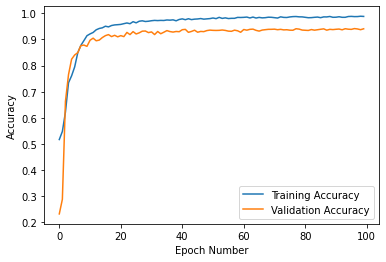

In [20]:
x = [i for i in range(no_epochs)]
# plot lines
plt.plot(x, train_accs, label = "Training Accuracy")
plt.plot(x, val_accs, label = "Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
dev_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
dev_predictions = []
dev_targets = []

for data, target in tqdm(dev_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    dev_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    pred_list = np.squeeze(pred.cpu().numpy())
    target_list = np.squeeze(target.cpu().numpy())
    dev_predictions.extend(pred_list)
    dev_targets.extend(target_list)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
#     print('target',target)
#     print('##################################################')
#     print('output',output)
#     print('##################################################')
#     print('pred',pred)
#     print('##################################################')
#     print('correct_tensor',correct_tensor)
#     print('##################################################')
#     print('correct',correct)
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print('class_correct',class_correct)
# print('##################################################')
# print('class_total',class_total)

dev_loss = dev_loss / dev_data_len
print('Dev Loss: {:.4f}'.format(dev_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Dev Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Dev accuracy of %5s: NA" % (classes[i]))
print("Dev Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 283/283 [00:59<00:00,  4.79it/s]

Dev Loss: 0.0001
Dev Accuracy of  fake: 95% (6592/6932)
Dev Accuracy of  true: 91% (1905/2092)
Dev Accuracy of 94% (8497/9024)


In [22]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
test_predictions = []
test_targets = []

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    pred_list = np.squeeze(pred.cpu().numpy())
    target_list = np.squeeze(target.cpu().numpy())
    test_predictions.extend(pred_list)
    test_targets.extend(target_list)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
#     print('target',target)
#     print('##################################################')
#     print('output',output)
#     print('##################################################')
#     print('pred',pred)
#     print('##################################################')
#     print('correct_tensor',correct_tensor)
#     print('##################################################')
#     print('correct',correct)
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# print('class_correct',class_correct)
# print('##################################################')
# print('class_total',class_total)

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))



100%|██████████| 243/243 [00:50<00:00,  4.77it/s]

Test Loss: 0.0015
Test Accuracy of  fake: 83% (5169/6168)
Test Accuracy of  true: 88% (1388/1576)
Test Accuracy of 84% (6557/7744)


In [23]:
# print('Target Labels: ',len(targets))
# print('Prediction Labels: ',len(predictions))

In [24]:
#EER
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
   
    return eer

test_EER = compute_eer(test_targets,test_predictions)
dev_EER = compute_eer(dev_targets,dev_predictions)

print('The EER for Dev is: {:.2f}'.format(dev_EER))
print('The EER for Test is: {:.2f}'.format(test_EER))

The EER for Dev is: 0.07
The EER for Test is: 0.14


In [25]:
#HTER
def calculate_HTER(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    far = fp / (fp + tn)
    frr = fn / (tp + fn)
    hter = (far + frr) / 2
    return hter


dev_hter = calculate_HTER(dev_targets, dev_predictions)
print('The HTER for Dev is: {:.2f}'.format(dev_hter))

test_hter = calculate_HTER(test_targets, test_predictions)
print('The HTER for Test is: {:.2f}'.format(test_hter))



The HTER for Dev is: 0.07
The HTER for Test is: 0.14


In [26]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("protocol1_model.pt")

In [27]:
#APCER, BPCER, ACER
test_attack_types = [ (1 if x==1 else 2) for x in test_targets]
dev_attack_types = [ (1 if x==1 else 2) for x in dev_targets]


# returns the metrics APCER, BPCER and ACER
test_apcer, test_bpcer, test_acer = oulumetrics.calculate_metrics(test_attack_types, test_predictions)
dev_apcer, dev_bpcer, dev_acer = oulumetrics.calculate_metrics(dev_attack_types, dev_predictions)

print('######## Dev Oulu Metrics ##########')
print('APCER: {:.2f}'.format(dev_apcer))
print('BPCER: {:.2f}'.format(dev_bpcer))
print('ACER: {:.2f}'.format(dev_acer))

print('######## Test Oulu Metrics ##########')
print('APCER: {:.2f}'.format(test_apcer))
print('BPCER: {:.2f}'.format(test_bpcer))
print('ACER: {:.2f}'.format(test_acer))





######## Dev Oulu Metrics ##########
APCER: 0.05
BPCER: 0.09
ACER: 0.07
######## Test Oulu Metrics ##########
APCER: 0.16
BPCER: 0.12
ACER: 0.14
